<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Анализ-поведения-абонентов-разных-тарифов" data-toc-modified-id="Анализ-поведения-абонентов-разных-тарифов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ поведения абонентов разных тарифов</a></span></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка гипотез</a></span></li></ul></div>

# Определение перспективного тарифа для телеком-компании #

## Описание проекта
Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на выборке из 500 клиентов компании. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов


Тариф **«Смарт»**:
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
*	минута разговора: 3 рубля
*	сообщение: 3 рубля
*	1 Гб интернет-трафика: 200 рублей

Тариф **«Ультра»**:
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
*	минута разговора: 1 рубль
*	сообщение: 1 рубль
*	1 Гб интернет-трафика: 150 рублей

Описание данных:

Таблица **users** (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана


Таблица **calls** (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


Таблица **messages** (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение


Таблица **internet** (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


Таблица **tariffs** (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib

Сначала ознакомимся со всеми 5 таблицами. Проанализируем их содержимое и наличие пропусков, ошибок и дубликатов.

In [2]:
try: 
    calls = pd.read_csv('datasets/calls.csv')
except FileNotFoundError:
    calls = pd.read_csv('/datasets/calls.csv') 

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [5]:
try: 
    internet = pd.read_csv('datasets/internet.csv', index_col=0)
except FileNotFoundError:
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)    

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [8]:
try: 
    messages = pd.read_csv('datasets/messages.csv')    
except FileNotFoundError:
    messages = pd.read_csv('/datasets/messages.csv')        

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [11]:
try: 
    tariffs = pd.read_csv('datasets/tariffs.csv')   
except FileNotFoundError:
    tariffs = pd.read_csv('/datasets/tariffs.csv') 

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
try: 
    users = pd.read_csv('datasets/users.csv')   
except FileNotFoundError:
    users = pd.read_csv('/datasets/users.csv')
    

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Мы проанализировали 5 таблиц. В датафреймах calls, internet, messages и tariffs нет пропусков, но необходимо изменить формат данных в столбцах call_date, session_date и message_date на datetime. В таблице users есть пропущенные значения в столбце churn_date. 

## Предобработка данных

В таблице calls нет пропущенных значений. Но необходимо изменить формат данных в столбце call_date в datetime. В столбце звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


В таблице internet нет пропущенных значений. Но также необходимо изменить формат столбца session_date на datetime. В столбце с объемом трафика есть строки с нулевой продолжительностью. Это значит, что абонент не пользовался интернетом в этот день.

In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


В таблице messages нет пропущенных значений. Изменяем формат столбца message_date на datetime.

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Таблицу tariffs оставляем без изменений.

В таблице user в столбце churn_date есть пропущенные значения. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Пропуски заполнять не нужно.

Проверим столбцы на наличие ошибок.

In [23]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Звонки длились от 0 (пропущенные) до 38 минут, что адекватно действительности.

Text(0, 0.5, 'Количество звонков')

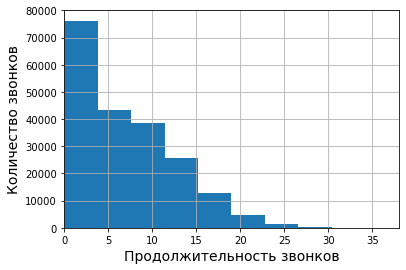

In [24]:
calls['duration'].plot(kind = 'hist', bins = 10, xlim = (0, 38), grid = True)
plt.xlabel('Продолжительность звонков', fontsize=14)
plt.ylabel('Количество звонков', fontsize=14)

Как видно на гистограмме, большая часть звонков длилась меньше 5 минут, таких звонков было более 70 тыс. 75% звонков было менее 11 минут. Максимальная продолжительность звонка составляла 38 минут.

In [25]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Чаще всего пользователи используют меньше 200 мб за одну сессию. 

Text(0, 0.5, 'Количество сессий')

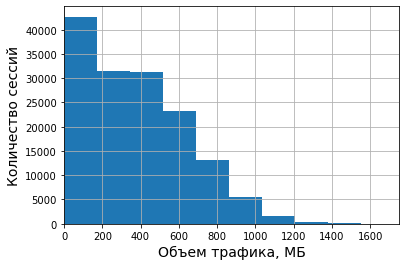

In [26]:
internet['mb_used'].plot(kind = 'hist', bins = 10, xlim = (0, 1750), grid = True)
plt.xlabel('Объем трафика, МБ', fontsize=14)
plt.ylabel('Количество сессий', fontsize=14)

In [27]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Text(0, 0.5, 'Количество абонентов')

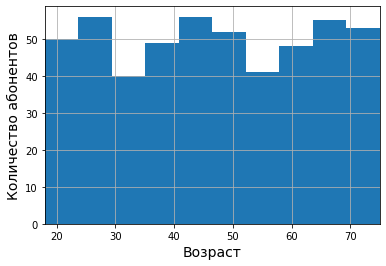

In [28]:
users['age'].plot(kind = 'hist', bins = 10, xlim = (18, 75), grid = True)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество абонентов', fontsize=14)

Все абоненты "Мегалайна" распределены по возрастам примерно в равном количестве. Их возраст колеблется от 18 до 75 лет.

In [29]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Ошибок в данных не обнаружено. Построим сводные таблицы с данными помесячно.

Сначала окргулим секунды но минуты, так как в "Мегалайне" каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Затем добавим столбец с порядковым значением месяца в таблицы.

In [30]:
calls['duration'] = np.ceil(calls['duration'])

In [31]:
calls['month'] = calls['call_date'].dt.month

In [32]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [33]:
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['count', 'sum'])
calls_pivot

count      sum
              duration duration
user_id month                  
1000    5           22    159.0
        6           43    172.0
        7           47    340.0
        8           52    408.0
        9           58    466.0
...                ...      ...
1498    10          41    247.0
1499    9            9     70.0
        10          68    449.0
        11          74    612.0
        12          69    492.0

[3174 rows x 2 columns]

In [34]:
calls_pivot.columns = ['calls', 'calls_duration']
calls_pivot

calls  calls_duration
user_id month                       
1000    5         22           159.0
        6         43           172.0
        7         47           340.0
        8         52           408.0
        9         58           466.0
...              ...             ...
1498    10        41           247.0
1499    9          9            70.0
        10        68           449.0
        11        74           612.0
        12        69           492.0

[3174 rows x 2 columns]

In [35]:
internet['month'] = internet['session_date'].dt.month

In [36]:
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [37]:
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [38]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [39]:
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'message_date', aggfunc = 'count')
messages_pivot

message_date
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

In [40]:
messages_pivot.columns = ['messages']
messages_pivot

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

Объединим таблицы в одну.

In [41]:
final_pivot = calls_pivot.merge(internet_pivot, how = 'outer', on = ['user_id', 'month'])
final_pivot


calls  calls_duration   mb_used
user_id month                                 
1000    5       22.0           159.0   2253.49
        6       43.0           172.0  23233.77
        7       47.0           340.0  14003.64
        8       52.0           408.0  14055.93
        9       58.0           466.0  14568.91
...              ...             ...       ...
1489    8        NaN             NaN  11050.56
        9        NaN             NaN  17206.30
        10       NaN             NaN  19559.44
        11       NaN             NaN  17491.56
        12       NaN             NaN  17322.51

[3214 rows x 3 columns]

In [42]:
final_pivot = final_pivot.merge(messages_pivot, how = 'outer', on = ['user_id', 'month'])
final_pivot

calls  calls_duration   mb_used  messages
user_id month                                           
1000    5       22.0           159.0   2253.49      22.0
        6       43.0           172.0  23233.77      60.0
        7       47.0           340.0  14003.64      75.0
        8       52.0           408.0  14055.93      81.0
        9       58.0           466.0  14568.91      57.0
...              ...             ...       ...       ...
1489    8        NaN             NaN  11050.56      17.0
        9        NaN             NaN  17206.30      32.0
        10       NaN             NaN  19559.44      21.0
        11       NaN             NaN  17491.56      20.0
        12       NaN             NaN  17322.51      35.0

[3214 rows x 4 columns]

In [43]:
final_pivot = final_pivot.merge(users, how = 'left', on = 'user_id')
final_pivot

,user_id,calls,calls_duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,22.0,159.0,2253.49,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,43.0,172.0,23233.77,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,47.0,340.0,14003.64,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,52.0,408.0,14055.93,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,58.0,466.0,14568.91,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,NaN,NaN,11050.56,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3210,1489,NaN,NaN,17206.30,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3211,1489,NaN,NaN,19559.44,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,NaN,NaN,17491.56,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [44]:
final_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   calls           3174 non-null   float64
 2   calls_duration  3174 non-null   float64
 3   mb_used         3203 non-null   float64
 4   messages        2717 non-null   float64
 5   age             3214 non-null   int64  
 6   churn_date      187 non-null    object 
 7   city            3214 non-null   object 
 8   first_name      3214 non-null   object 
 9   last_name       3214 non-null   object 
 10  reg_date        3214 non-null   object 
 11  tariff          3214 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 326.4+ KB


По результатам месяца компания "Мегалайн" округляет длительность разговоров до минут, а мегабайты — до гигабайт.

In [45]:
final_pivot['gb_used'] = np.ceil(final_pivot['mb_used'] / 1024)

In [46]:
display(final_pivot)

,user_id,calls,calls_duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used
0,1000,22.0,159.0,2253.49,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0
1,1000,43.0,172.0,23233.77,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23.0
2,1000,47.0,340.0,14003.64,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14.0
3,1000,52.0,408.0,14055.93,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14.0
4,1000,58.0,466.0,14568.91,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,NaN,NaN,11050.56,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,11.0
3210,1489,NaN,NaN,17206.30,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,17.0
3211,1489,NaN,NaN,19559.44,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,20.0
3212,1489,NaN,NaN,17491.56,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,18.0


Удалим столбцы, которые не нужны нам для анализа.

In [47]:
del final_pivot['churn_date']
del final_pivot['first_name']
del final_pivot['last_name']
del final_pivot['reg_date']
del final_pivot['mb_used']

In [48]:
final_pivot

,user_id,calls,calls_duration,messages,age,city,tariff,gb_used
0,1000,22.0,159.0,22.0,52,Краснодар,ultra,3.0
1,1000,43.0,172.0,60.0,52,Краснодар,ultra,23.0
2,1000,47.0,340.0,75.0,52,Краснодар,ultra,14.0
3,1000,52.0,408.0,81.0,52,Краснодар,ultra,14.0
4,1000,58.0,466.0,57.0,52,Краснодар,ultra,15.0
...,...,...,...,...,...,...,...,...
3209,1489,NaN,NaN,17.0,35,Санкт-Петербург,smart,11.0
3210,1489,NaN,NaN,32.0,35,Санкт-Петербург,smart,17.0
3211,1489,NaN,NaN,21.0,35,Санкт-Петербург,smart,20.0
3212,1489,NaN,NaN,20.0,35,Санкт-Петербург,smart,18.0


In [49]:
tariffs = tariffs.rename(columns = {'tariff_name':'tariff'})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [50]:
final_pivot = final_pivot.merge(tariffs, how = 'left', on = 'tariff')
final_pivot

,user_id,calls,calls_duration,messages,age,city,tariff,gb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,22.0,159.0,22.0,52,Краснодар,ultra,3.0,1000,30720,3000,1950,150,1,1
1,1000,43.0,172.0,60.0,52,Краснодар,ultra,23.0,1000,30720,3000,1950,150,1,1
2,1000,47.0,340.0,75.0,52,Краснодар,ultra,14.0,1000,30720,3000,1950,150,1,1
3,1000,52.0,408.0,81.0,52,Краснодар,ultra,14.0,1000,30720,3000,1950,150,1,1
4,1000,58.0,466.0,57.0,52,Краснодар,ultra,15.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,NaN,NaN,17.0,35,Санкт-Петербург,smart,11.0,50,15360,500,550,200,3,3
3210,1489,NaN,NaN,32.0,35,Санкт-Петербург,smart,17.0,50,15360,500,550,200,3,3
3211,1489,NaN,NaN,21.0,35,Санкт-Петербург,smart,20.0,50,15360,500,550,200,3,3
3212,1489,NaN,NaN,20.0,35,Санкт-Петербург,smart,18.0,50,15360,500,550,200,3,3


In [51]:
def month_revenue(row):
    tariff = row['tariff']
    minutes = row['calls_duration']
    messages = row['messages']
    tariff_fee = row['rub_monthly_fee']
    internet = row['gb_used']
    minutes_included = row['minutes_included']
    minute_price = row['rub_per_minute']
    messages_included = row['messages_included']
    message_price = row['rub_per_message']
    gb_included = row['mb_per_month_included'] / 1024
    gb_price = row['rub_per_gb']
    
    if tariff == 'smart':
        if minutes > minutes_included:
            over_min = (minutes - minutes_included) * minute_price
        else: 
            over_min = 0
        if messages > messages_included:
            over_mes = (messages - messages_included) * message_price
        else:
            over_mes = 0
        if internet > gb_included:
            over_gb = (internet - gb_included) * gb_price
        else:
            over_gb = 0
    elif tariff == 'ultra':
        if minutes > minutes_included:
            over_min = (minutes - minutes_included) * minute_price
        else: 
            over_min = 0
        if messages > messages_included:
            over_mes = (messages - messages_included) * message_price
        else:
            over_mes = 0
        if internet > gb_included:
            over_gb = (internet - gb_included) * gb_price
        else:
            over_gb = 0
    return tariff_fee + over_min + over_mes + over_gb   
    


Далее посчитаем размер ежемесячной выручки с каждого клиента.

In [52]:
final_pivot['monthly_revenue'] = final_pivot.apply(month_revenue, axis = 1)   
final_pivot

,user_id,calls,calls_duration,messages,age,city,tariff,gb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,monthly_revenue
0,1000,22.0,159.0,22.0,52,Краснодар,ultra,3.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,43.0,172.0,60.0,52,Краснодар,ultra,23.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,47.0,340.0,75.0,52,Краснодар,ultra,14.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52.0,408.0,81.0,52,Краснодар,ultra,14.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,58.0,466.0,57.0,52,Краснодар,ultra,15.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,NaN,NaN,17.0,35,Санкт-Петербург,smart,11.0,50,15360,500,550,200,3,3,550.0
3210,1489,NaN,NaN,32.0,35,Санкт-Петербург,smart,17.0,50,15360,500,550,200,3,3,950.0
3211,1489,NaN,NaN,21.0,35,Санкт-Петербург,smart,20.0,50,15360,500,550,200,3,3,1550.0
3212,1489,NaN,NaN,20.0,35,Санкт-Петербург,smart,18.0,50,15360,500,550,200,3,3,1150.0


In [53]:
final_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   calls                  3174 non-null   float64
 2   calls_duration         3174 non-null   float64
 3   messages               2717 non-null   float64
 4   age                    3214 non-null   int64  
 5   city                   3214 non-null   object 
 6   tariff                 3214 non-null   object 
 7   gb_used                3203 non-null   float64
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
 15  mont

Оставшиеся пропуски занулим, так как это означает, что эти виды связи были не использованы абонентом.

In [54]:
final_pivot['calls'] = final_pivot['calls'].fillna(0)
final_pivot['calls_duration'] = final_pivot['calls_duration'].fillna(0)
final_pivot['messages'] = final_pivot['messages'].fillna(0)
final_pivot['gb_used'] = final_pivot['gb_used'].fillna(0)

In [55]:
final_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   calls                  3214 non-null   float64
 2   calls_duration         3214 non-null   float64
 3   messages               3214 non-null   float64
 4   age                    3214 non-null   int64  
 5   city                   3214 non-null   object 
 6   tariff                 3214 non-null   object 
 7   gb_used                3214 non-null   float64
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
 15  mont

Предобработка закончена.

## Анализ поведения абонентов разных тарифов

Опишем поведение клиентов оператора, исходя из выборки. Сначала создадим 2 таблицы с данными для двух разных тарифов. 

In [56]:
smart_clients = final_pivot.loc[final_pivot['tariff'] == 'smart']
ultra_clients = final_pivot.loc[final_pivot['tariff'] == 'ultra']


In [57]:
smart_clients['calls_duration'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: calls_duration, dtype: float64

In [58]:
ultra_clients['calls_duration'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: calls_duration, dtype: float64

In [59]:
var_est_calls_smart = np.var(smart_clients['calls_duration'], ddof = 1)
st_dev_calls_smart = np.std(smart_clients['calls_duration'], ddof = 1)
mean_calls_smart = smart_clients['calls_duration'].mean()

var_est_calls_ultra = np.var(ultra_clients['calls_duration'], ddof = 1)
st_dev_calls_ultra = np.std(ultra_clients['calls_duration'], ddof = 1)
mean_calls_ultra = ultra_clients['calls_duration'].mean()

desc = [{"tariff_name": 'smart', "mean": mean_calls_smart, "variation_estimated": var_est_calls_smart, "standard_deviation": st_dev_calls_smart}, {"tariff_name": 'ultra', "mean": mean_calls_ultra, "variation_estimated": var_est_calls_ultra, "standard_deviation": st_dev_calls_ultra}]
description_calls = pd.DataFrame(desc)
display(description_calls)

,tariff_name,mean,variation_estimated,standard_deviation
0,smart,417.934948,36219.315784,190.313730
1,ultra,526.623350,100873.633397,317.606098


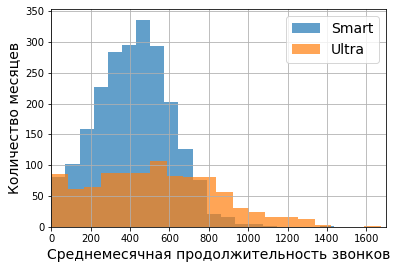

In [60]:
ax = smart_clients['calls_duration'].plot(kind = 'hist', bins = 20, xlim = (0, 1700), grid = True, alpha = 0.7, label = 'Smart')
ultra_clients['calls_duration'].plot(kind = 'hist', bins = 20, xlim = (0, 1700), ax=ax, grid = True, alpha = 0.7, label = 'Ultra')
plt.xlabel('Среднемесячная продолжительность звонков', fontsize=14)
plt.ylabel('Количество месяцев', fontsize=14)
plt.legend(fontsize=14)

Количество абонентов в выборке, использующих тариф "Смарт" почти в 2,5 раза больше, чем абонентов с тарифом "Ультра". Данный факт можно объяснить разницей в размере абонентской платы. "Ультра" почти в 4 раза дороже "Смарта".

В среднем абоненты "Смарта" разговаривают 418 минут в месяц, а "Ультры" - 527. Ни в том, ни другом случае средние показатели не выходят за рамки установленного лимита. Кроме того, ни один из абонентов "Ультры" не вышел за рамки установленного лимита.

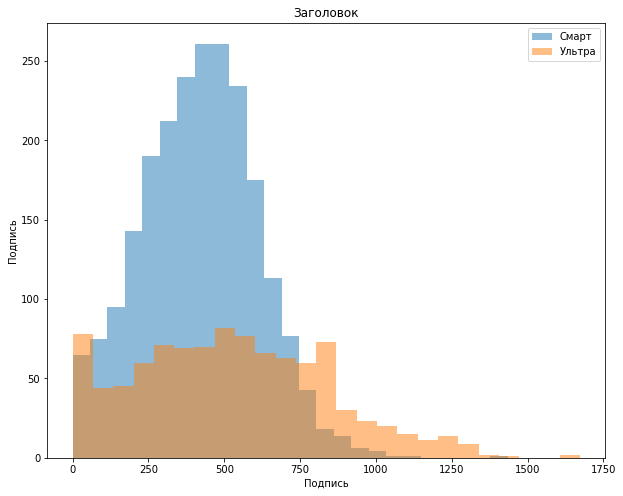

In [61]:
# КОД РЕВЬЮЕРА 2

final_pivot.groupby('tariff')['calls_duration'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Смарт', 'Ультра'])
plt.title('Заголовок')
plt.xlabel('Подпись')
plt.ylabel('Подпись')

plt.show()

In [62]:
smart_clients['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [63]:
ultra_clients['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

In [64]:
var_est_mes_smart = np.var(smart_clients['messages'], ddof = 1)
st_dev_mes_smart = np.std(smart_clients['messages'], ddof = 1)
mean_mes_smart = smart_clients['messages'].mean()

var_est_mes_ultra = np.var(ultra_clients['messages'], ddof = 1)
st_dev_mes_ultra = np.std(ultra_clients['messages'], ddof = 1)
mean_mes_ultra = ultra_clients['messages'].mean()

desc = [{"tariff_name": 'smart', "mean": mean_mes_smart, "variation_estimated": var_est_mes_smart, "standard_deviation": st_dev_mes_smart}, {"tariff_name": 'ultra', "mean": mean_mes_ultra, "variation_estimated": var_est_mes_ultra, "standard_deviation": st_dev_mes_ultra}]
description_messages = pd.DataFrame(desc)
display(description_messages)

,tariff_name,mean,variation_estimated,standard_deviation
0,smart,33.384029,796.812958,28.227876
1,ultra,49.363452,2285.266143,47.804457


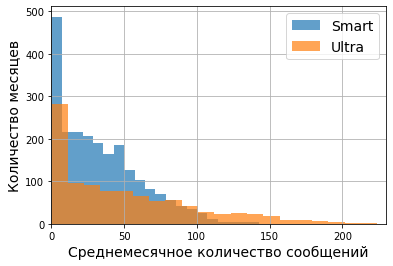

In [65]:
ax = smart_clients['messages'].plot(kind = 'hist', bins = 20, xlim = (0, 230), grid = True, alpha = 0.7, label = 'Smart')
ultra_clients['messages'].plot(kind = 'hist', bins = 20, xlim = (0, 230), ax=ax, grid = True, alpha = 0.7, label = 'Ultra')
plt.xlabel('Среднемесячное количество сообщений', fontsize=14)
plt.ylabel('Количество месяцев', fontsize=14)
plt.legend(fontsize=14)

Абоненты "Ультры" в среднем отправляют в 1,5 раза больше сообщений, чем абоненты "Смарт": 49 и 33 сообщений в месяц соответственно. Среднее также не превышает установленный лимит. В целом, судя по графику, можно сказать, что много месяцев, где количество сообщений почти минимальное. Абоненты "Ультры" вообще никогда не превышают установленный лимит в 1000 сообщений.

In [66]:
smart_clients['gb_used'].describe()

count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

In [67]:
ultra_clients['gb_used'].describe()

count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

In [68]:
var_est_gb_smart = np.var(smart_clients['gb_used'], ddof = 1)
st_dev_gb_smart = np.std(smart_clients['gb_used'], ddof = 1)
mean_gb_smart = smart_clients['gb_used'].mean()

var_est_gb_ultra = np.var(ultra_clients['gb_used'], ddof = 1)
st_dev_gb_ultra = np.std(ultra_clients['gb_used'], ddof = 1)
mean_gb_ultra = ultra_clients['gb_used'].mean()

desc = [{"tariff_name": 'smart', "mean": mean_gb_smart, "variation_estimated": var_est_gb_smart, "standard_deviation": st_dev_gb_smart}, {"tariff_name": 'ultra', "mean": mean_gb_ultra, "variation_estimated": var_est_gb_ultra, "standard_deviation": st_dev_gb_ultra}]
description_gb= pd.DataFrame(desc)
display(description_gb)

,tariff_name,mean,variation_estimated,standard_deviation
0,smart,16.328847,33.028705,5.747061
1,ultra,19.494416,97.091686,9.853511


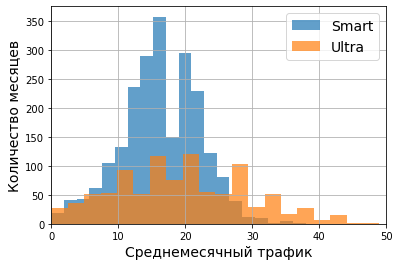

In [69]:
ax = smart_clients['gb_used'].plot(kind = 'hist', bins = 20, xlim = (0, 50), grid = True, alpha = 0.7, label = 'Smart')
ultra_clients['gb_used'].plot(kind = 'hist', bins = 20, xlim = (0, 50), ax=ax, grid = True, alpha = 0.7, label = 'Ultra')
plt.xlabel('Среднемесячный трафик', fontsize=14)
plt.ylabel('Количество месяцев', fontsize=14)
plt.legend(fontsize=14)

Среднемесячный объем интернет-трафика для абонентов обоих тарифов отличается несущественно: 16 ГБ для "Смарта" и 20 ГБ для "Ультры". В среднемесячный объем трафика абонентов "Смарта" превышает установленный лимит, а абонентов "Ультры" нет. Тем не менее, у обоих тарифов есть клиенты, которые превышают месячный лимит.

Таким образом, пользователи тарифа "Смарт" чаще нарушают лимиты и платят за дополнительные минуты разговора, сообщения и Интернет-трафик. Также, исходя из анализа, абоненты чаще используют Интернет-связь и звонки, чем смс-сообщения. 

## Проверка гипотез

Проверим следующие гипотезы:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Н0: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются;

Н1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Пороговое значение alpha - 5%, так как его используют чаще всего. 

In [70]:
alpha = 0.05
results = scipy.stats.ttest_ind(smart_clients['monthly_revenue'], ultra_clients['monthly_revenue'], equal_var = False)
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Проверка показала, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [71]:
var_est_rev_smart = np.var(smart_clients['monthly_revenue'], ddof = 1)
st_dev_rev_smart = np.std(smart_clients['monthly_revenue'], ddof = 1)
mean_rev_smart = smart_clients['monthly_revenue'].mean()

var_est_rev_ultra = np.var(ultra_clients['monthly_revenue'], ddof = 1)
st_dev_rev_ultra = np.std(ultra_clients['monthly_revenue'], ddof = 1)
mean_rev_ultra = ultra_clients['monthly_revenue'].mean()

desc = [{"tariff_name": 'smart', "mean": mean_rev_smart, "variation_estimated": var_est_rev_smart, "standard_deviation": st_dev_rev_smart}, {"tariff_name": 'ultra', "mean": mean_rev_ultra, "variation_estimated": var_est_rev_ultra, "standard_deviation": st_dev_rev_ultra}]
description_messages = pd.DataFrame(desc)
display(description_messages)

,tariff_name,mean,variation_estimated,standard_deviation
0,smart,1289.973531,669785.708006,818.404367
1,ultra,2070.152284,141516.745079,376.187114


Среднемесячная выручка от абонентов "Смарт" равна 1290 рублей (то есть 2,4 раза выше размера тарифа), а тарифа "Ультра" 2070 рублей, что несущественно выше размера тарифа. Посчитаем объем выручки от клиентов каждого тарифа:

In [72]:
smart_total_revenue = mean_mes_smart * len(smart_clients['monthly_revenue'])
smart_total_revenue

74413.0

In [73]:
ultra_total_revenue = mean_mes_ultra * len(ultra_clients['monthly_revenue'])
ultra_total_revenue

48623.0

Создадим 2 таблицы: в первой будут пользователи из Москвы, во второй из других регионов.

In [74]:
moscow_revenue = final_pivot.loc[final_pivot['city'] == 'Москва', 'monthly_revenue']
other_revenue = final_pivot.loc[final_pivot['city'] != 'Москва', 'monthly_revenue']

Н0: средняя выручка пользователей из Москвы и регионов не различаются; 

Н1: средняя выручка пользователей из Москвы и регионов различаются;

In [75]:
alpha = 0.05
results = scipy.stats.ttest_ind(moscow_revenue, other_revenue, equal_var = False)
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть гипотезу о том, что средняя выручка в Москве и регионах отличается.

In [76]:
var_est_moscow = np.var(moscow_revenue, ddof = 1)
st_dev_moscow = np.std(moscow_revenue, ddof = 1)
mean_moscow = moscow_revenue.mean()

var_est_other = np.var(other_revenue, ddof = 1)
st_dev_other = np.std(other_revenue, ddof = 1)
mean_other = other_revenue.mean()

desc = [{"region": 'Moscow', "mean": mean_moscow, "variation_estimated": var_est_moscow, "standard_deviation": st_dev_moscow}, {"region": 'Other', "mean": mean_other, "variation_estimated": var_est_other, "standard_deviation": st_dev_other}]
description_messages = pd.DataFrame(desc)
display(description_messages)

,region,mean,variation_estimated,standard_deviation
0,Moscow,1546.713584,565636.467012,752.088071
1,Other,1524.936227,654137.628522,808.787752


Таким образом, средний размер выручки от абонентов тарифа "Смарт" отличается от средней выручки тарифа "Ультра". Больше общей  выручки компания получает от тарифа "Смарт", так количество абонентов "Смарта" в несколько раз выше, чем тарифа "Ультра" и они чаще превышают установленные лимиты.
При этом, средний размер выручки не зависит от региона проживания клиента.





В ходе исследования была проанализирована выборка из 500 абонентов телеком-компании "Мегалайн". В ней указано: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Цель исследования: узнать, какой тариф лучше.

В ходе предобработки данных было выявлено, что пропусков, которые необходимо заполнить нет. Ошибок и дубликатов тоже. 

Анализ поведения абонетов двух тарифов показал:
* количество абонентов в выборке, использующих тариф "Смарт" почти в 2,5 раза больше, чем абонентов с тарифом "Ультра". Данный факт можно объяснить разницей в размере абонентской платы. "Ультра" почти в 4 раза дороже "Смарта".
* в среднем абоненты "Смарта" разговаривают 418 минут в месяц, а "Ультры" - 527. Ни в том, ни другом случае средние показатели не выходят за рамки установленного лимита. Кроме того, ни один из абонентов "Ультры" не вышел за рамки установленного лимита.
* абоненты "Ультры" в среднем отправляют в 1,5 раза больше сообщений, чем абоненты "Смарта": 49 и 33 сообщений в месяц соответственно. Среднее также не превышает установленный лимит. В целом, судя по графику, можно сказать, что много месяцев, где количество сообщений менее 10. Абоненты "Ультры" вообще никогда не превышают установленный лимит в 1000 сообщений.
* среднемесячный объем интернет-трафика для абонентов обоих тарифов отличается несущественно: 16 ГБ для "Смарта" и 20 ГБ для "Ультры". Среднемесячный объем трафика абонентов "Смарта" превышает установленный лимит, а абонентов "Ультры" нет. Тем не менее, у обоих тарифов есть клиенты, которые превышают месячный лимит.
* абоненты чаще используют Интернет-связь и звонки, чем смс-сообщения.
* средний размер выручки от абонентов тарифа "Смарт" отличается от средней выручки тарифа "Ультра". Среднемесячная выручка от абонентов "Смарт" равна 1290 рублей (то есть 2,4 раза выше размера тарифа), а тарифа "Ультра" 2070 рублей, что несущественно выше размера тарифа. 
* согласно выборке, больше общей  выручки компания получает от тарифа "Смарт", так количество абонентов "Смарта" в несколько раз выше, чем тарифа "Ультра" и они чаще превышают установленные лимиты.
* средний размер выручки не зависит от региона проживания клиента.

